# Project 2: 
# DSI-US-6 Project 2 Regression Challenge
## Predict the price of homes at sale for the Aimes Iowa Housing dataset

## Table of Contents:

### Part 1

1. [Background](#1.-Background)  
1. [Problem Statement](#2.-Problem-Statement)  
1. [Executive Summary](#3.-Executive-Summary)  
1. [Data Cleaning](#4.-Data-Cleaning)  
    1. [Data Dictionary](#a.-Data-Dictionary)
1. [Exploratory Data Analysis](#5.-Exploratory-Data-Analysis)  
1. [Features Selection](#6.-Features-Selection)  
    1. [Quantitative](#a.-Quantitative)  
    1. [Qualitative](#b.-Qualitative)
    1. [Summary](#c.-Features-Selection-Summary) 
    
### Part 2
7. [Modeling](#7.-Modeling)    
    1. [Base Case](#a.-Base-Case)
1. [Fine Tuning](#8.-Fine-Tuning)  
    1. [Model 1](#a.-Model-1:-Log-y-with-LR-with-same-features-as-baseline-case)
    1. [Model 2](#b.-Model-2:-LR-with-same-features-as-baseline-case-and-Polynominal)
    1. [Model 3](#c.-Model-3:-Lasso-with-same-features-as-baseline-case-and-Polynominal)
    1. [Model 4](#d.-Model-4:-Ridge-with-same-features-as-baseline-case-and-Polynominal)
    1. [Model 5](#e.-Model-5:-Ridge-with-more-features-and-Polynominal)  
    1. [Final Model](#f.-Final-model)
1. [Conclusion and Recommendations](#9.-Conclusion-and-Recommendations)  
1. [References and Data Sources](#10.-References-and-Data-Sources) 

## 1. Background

We are given a Kaggle challenge to build a regression model based on the Ames housing data to **predict** the **sale price** for each house in Aimes Iowa. The data given include a train dataset with sales price in it and a test dataset without sales price in it.

## 2. Problem Statement

To create a regression model that will **predict** the **sale price** for each house in Aimes Iowa. Using the train set to build the model and using the test set to test the **RMSE** score achieve by the model. The aim is to achieve the lowest **RMSE** on the test dataset.

## 3. Executive Summary

From the RMSE of the different models, our best model is Model 5 which have a RMSE score of 22873 on our holding set and 24842 on the Kaggle Test set. This model is a Ridge Regression model with 19 features, polynomised the continuous and ordinate data to a order of 2 and one hot encode the nominal data. 

Our strategy on the EDA was to categorised the features into quantitative and qualitative data and then into similar characteristics like sizes and quality etc. For each group, we try to filter out the features which have little or no correlation with the SalePrice and also those which are not effective is categorizing the SalePrice into different ranges. We also look at the interaction between the features and if they are correlated with one another. 

We discover that year built, ground living area, total rooms of the house and value of miscellanous features impact the Sale price greatly. Newer, bigger ground living area and higher total rooms increase the Sale price. Surprisingly lot area doesn't add alot more value to the Sale price as much as the ground living area. Excellent external quality and overall quality also add value to the SalePrice. Bigger garage area and bulit-in garage type and new sale type also contribute greatly to increase the SalePrice. Homeowners who are looking to increase their sale price can renovate a built in garage and improve the quality of their exterior material. The neighbourhoods with higher SalePrice are Stone Brook and Northridge

From our base model,we notice that our predicted y underpredict for the range y more than 300,000. Also when we were doing EDA, a portion of the features show heteroskedasticity so we suspect interaction between the features which we try to linearise by using log y and adding polynominal features of order 2. We also used Ridge Regression to regularize the extra features in set 2. Both these help to reduce our RSME scores greatly.

## 4. Data Cleaning

#### a. Data Dictionary

https://www.kaggle.com/c/dsi-us-6-project-2-regression-challenge/data

In [1]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder, OrdinalEncoder
from sklearn import metrics
from sklearn.metrics import mean_squared_error

In [2]:
# import data

# training set
train_hold = pd.read_csv('../datasets/train.csv')
# kaggle test set
test = pd.read_csv('../datasets/test.csv')

In [3]:
train_hold.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


In [4]:
train_hold[train_hold['Mas Vnr Area'].isnull()][['Mas Vnr Type','Mas Vnr Area']].head()

,Mas Vnr Type,Mas Vnr Area
22,NaN,NaN
41,NaN,NaN
86,NaN,NaN
212,NaN,NaN
276,NaN,NaN


In [5]:
def cleandf(df):
    
    '''
    DocString
    ----------
    To replace NA values in dataframe which are due to naming but not actually missing values
       
    Parameters:
    ----------
    df:              Pandas DataFrame which contains the data
    
    '''
        
    df['Lot Frontage'].replace(np.nan, 0, inplace = True) # Notice that most of the NA values are with Lot inside lot or CulDSac so likely to be 0
    df['Alley'].replace(np.nan, 'None', inplace = True) # NA mean none as per data dictionary
    df['Mas Vnr Type'].replace(np.nan, 'None', inplace = True) # NA mean none as per data dictionary
    df['Mas Vnr Area'].replace(np.nan, 0, inplace = True) # NA mean none as per Mas Vnr Type
    df['Bsmt Qual'].replace(np.nan, 'None', inplace = True) # NA mean none as per data dictionary
    df['Bsmt Cond'].replace(np.nan, 'None', inplace = True) # NA mean none as per data dictionary
    df['Bsmt Exposure'].replace(np.nan, 'None', inplace = True) # NA mean none as per data dictionary
    df['BsmtFin Type 1'].replace(np.nan, 'None', inplace = True) # NA mean none as per data dictionary
    df['BsmtFin Type 2'].replace(np.nan, 'None', inplace = True) # NA mean none as per data dictionary
    df['Fireplace Qu'].replace(np.nan, 'None', inplace = True) # NA mean none as per data dictionary
    df['Garage Type'].replace(np.nan, 'None', inplace = True) # NA mean none as per data dictionary
    df['Garage Finish'].replace(np.nan, 'None', inplace = True) # NA mean none as per data dictionary
    df['Garage Qual'].replace(np.nan, 'None', inplace = True) # NA mean none as per data dictionary
    df['Garage Cond'].replace(np.nan, 'None', inplace = True) # NA mean none as per data dictionary
    df.drop(columns= ['Garage Yr Blt'], inplace = True) # drop the feature as we have year bulit
    df['Pool QC'].replace(np.nan, 'None', inplace = True) # NA mean none as per data dictionary
    df['Fence'].replace(np.nan, 'None', inplace = True) # NA mean none as per data dictionary
    df['Misc Feature'].replace(np.nan, 'None', inplace = True) # NA mean none as per data dictionary
    
    return df

In [6]:
# function to only return columns with NA values since dataframe too many columns to display

def checkna(df):
    col_missing_data = [x for x in df.columns if df[x].isnull().sum() != 0]
    return df[col_missing_data].isnull().sum()

##### a. Cleaning Train Set

In [7]:
# check NA value in train.csv
checkna(train_hold)

Lot Frontage       330
Alley             1911
Mas Vnr Type        22
Mas Vnr Area        22
Bsmt Qual           55
Bsmt Cond           55
Bsmt Exposure       58
BsmtFin Type 1      55
BsmtFin SF 1         1
BsmtFin Type 2      56
BsmtFin SF 2         1
Bsmt Unf SF          1
Total Bsmt SF        1
Bsmt Full Bath       2
Bsmt Half Bath       2
Fireplace Qu      1000
Garage Type        113
Garage Yr Blt      114
Garage Finish      114
Garage Cars          1
Garage Area          1
Garage Qual        114
Garage Cond        114
Pool QC           2042
Fence             1651
Misc Feature      1986
dtype: int64

In [8]:
train_hold = cleandf(train_hold)

In [9]:
checkna(train_hold)

BsmtFin SF 1      1
BsmtFin SF 2      1
Bsmt Unf SF       1
Total Bsmt SF     1
Bsmt Full Bath    2
Bsmt Half Bath    2
Garage Cars       1
Garage Area       1
dtype: int64

In [10]:
# since the number of rows with missing value is small, we can afford to drop this data
train_hold.dropna(inplace = True)

In [11]:
train_hold.columns

Index(['Id', 'PID', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area',
       'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities',
       'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', 'Roof Style',
       'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type',
       'Mas Vnr Area', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual',
       'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1',
       'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
       'Heating', 'Heating QC', 'Central Air', 'Electrical', '1st Flr SF',
       '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath',
       'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr',
       'Kitchen AbvGr', 'Kitchen Qual', 'TotRms AbvGrd', 'Functional',
       'Fireplaces', 'Fireplace Qu', 'Garage Type', 'Garage Finish',
       'G

In [12]:
len(train_hold.columns)

80

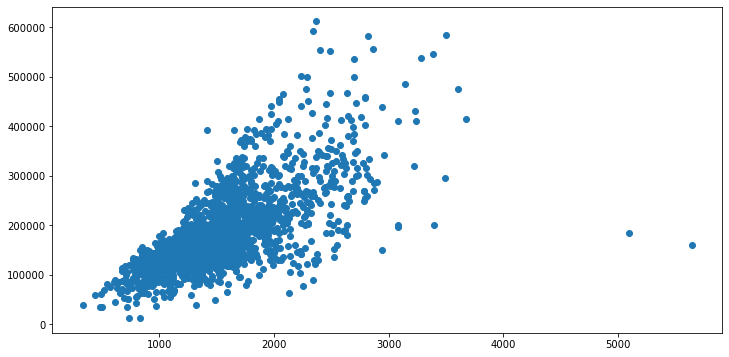

In [13]:
# cleaning up outliers data
plt.figure(figsize=(12,6))
plt.scatter(y=train_hold['SalePrice'], x=train_hold['Gr Liv Area'])

train_hold = train_hold[train_hold['Gr Liv Area'] < 4000]

As per the link in 'Readme.md' file, Section: 'Setup', Point '4. Review the data description.'
>SPECIAL NOTES:
There are 5 observations that an instructor may wish to remove from the data set before giving it to students (a plot of SALE PRICE versus GR LIV AREA will indicate them quickly). Three of them are true outliers (Partial Sales that likely don’t represent actual market values) and two of them are simply unusual sales (very large houses priced relatively appropriately). I would recommend removing any houses with more than 4000 square feet from the data set (which eliminates these 5 unusual observations) before assigning it to students.


<AxesSubplot:xlabel='SalePrice'>

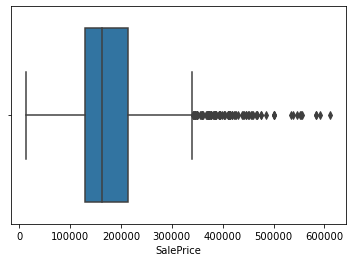

In [14]:
sns.boxplot(x=train_hold['SalePrice'])

The boxplot show that the majority of 'SalePrice' are below 350,000. 'SalePrice' above 350,000 are above 1.5 times of the 75 percentile.

In [15]:
train_hold[train_hold['SalePrice'] > 350000]

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
41,2383,528110050,20,RL,107.0,13891,Pave,None,Reg,Lvl,...,0,0,None,None,None,0,9,2006,New,465000
68,1707,528150040,20,RL,94.0,13615,Pave,None,IR1,HLS,...,0,0,None,None,None,0,6,2007,WD,372000
81,367,527214050,20,RL,63.0,17423,Pave,None,IR1,Lvl,...,0,0,None,None,None,0,7,2009,New,501837
100,1013,527214030,20,RL,53.0,15401,Pave,None,IR1,HLS,...,0,0,None,None,None,0,9,2008,WD,387000
138,2331,527210040,60,RL,60.0,18062,Pave,None,IR1,HLS,...,0,0,None,None,None,0,9,2006,New,545224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1964,1638,527216080,20,RL,52.0,51974,Pave,None,IR1,Lvl,...,322,0,None,None,None,0,6,2007,New,591587
2002,1056,528110080,20,RL,107.0,13891,Pave,None,Reg,Lvl,...,0,0,None,None,None,0,1,2008,New,372402
2029,969,921128050,20,RL,85.0,12633,Pave,None,IR1,HLS,...,0,0,None,None,None,0,5,2009,WD,425000
2041,1065,528166120,60,RL,110.0,13688,Pave,None,IR1,Lvl,...,0,0,None,None,None,0,3,2008,WD,412500


##### b. Cleaning Test Set

In [16]:
checkna(test)

Lot Frontage      160
Alley             821
Mas Vnr Type        1
Mas Vnr Area        1
Bsmt Qual          25
Bsmt Cond          25
Bsmt Exposure      25
BsmtFin Type 1     25
BsmtFin Type 2     25
Electrical          1
Fireplace Qu      422
Garage Type        44
Garage Yr Blt      45
Garage Finish      45
Garage Qual        45
Garage Cond        45
Pool QC           875
Fence             707
Misc Feature      838
dtype: int64

In [17]:
test = cleandf(test)

In [18]:
checkna(test)

Electrical    1
dtype: int64

In [19]:
test[test['Electrical'].isnull()]['Electrical']

635    NaN
Name: Electrical, dtype: object

Since the test data set still have null value in Electrical, we might consider to avoid using Electrical as a feature as we cannot drop the row.

In [20]:
# saving the cleaned data
train_hold.to_csv('../datasets/train_cleaned.csv', index=False)
test.to_csv('../datasets/test_cleaned.csv',index =False)

## 5. Exploratory Data Analysis

### Divide into quantitative and qualitative data (Divide and Conquer!)

Our strategy here is to breakdown all the given features in the training dataset into a(i) Quantitative discrete features a(ii) Quantitative continuous features, b(i) Qualitative Ordinal data and b(ii) Qualitative Nominal data. After which we will further group each dataset into identical features and select features which are independent. We will also discard the features where the distribution of the data might be too skewed to provide any real use in the modeling.

In [21]:
#split into qualitative and quantitative data
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
train_quant = train_hold.select_dtypes(include=numerics).copy(deep=True)
train_quali = train_hold.select_dtypes(exclude=numerics).copy(deep=True)

# ['MS SubClass', 'Overall Qual', 'Overall Cond'] are qualitative instead of quantitative
train_quali[['MS SubClass', 'Overall Qual', 'Overall Cond']] = train_quant[['MS SubClass', 'Overall Qual', 'Overall Cond']]
train_quant.drop(columns = ['MS SubClass', 'Overall Qual', 'Overall Cond'], inplace = True)

#### a. Quantitative.

In [22]:
train_quant.columns #number of quantitative features

Index(['Id', 'PID', 'Lot Frontage', 'Lot Area', 'Year Built', 'Year Remod/Add',
       'Mas Vnr Area', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF',
       'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF',
       'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath',
       'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'TotRms AbvGrd',
       'Fireplaces', 'Garage Cars', 'Garage Area', 'Wood Deck SF',
       'Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch',
       'Pool Area', 'Misc Val', 'Mo Sold', 'Yr Sold', 'SalePrice'],
      dtype='object')

#### i. Discrete

In [23]:
# further divide into groups with similarity
quant_id = ['Id','PID','SalePrice']
quant_time = ['Year Built','Year Remod/Add', 'Mo Sold','Yr Sold']
quant_room = ['Bsmt Full Bath','Bsmt Half Bath','Full Bath','Half Bath',
            'Bedroom AbvGr','Kitchen AbvGr','TotRms AbvGrd','Fireplaces']

#### ii. Continuous

In [24]:
# further divide into groups with similarity
quant_bsmt = ['BsmtFin SF 1','BsmtFin SF 2','Bsmt Unf SF','Total Bsmt SF']
quant_flr = ['1st Flr SF','2nd Flr SF','Gr Liv Area']
quant_porch = ['Open Porch SF','Enclosed Porch','3Ssn Porch','Screen Porch']
quant_overall = ['Lot Frontage','Lot Area','Low Qual Fin SF','Misc Val']
quant_rest = [x for x in train_quant.columns if x not in 
              quant_id+quant_time+quant_room+
              quant_bsmt+quant_flr+quant_porch+quant_overall]

#### b. Qualitative.

In [25]:
train_quali.columns

Index(['MS Zoning', 'Street', 'Alley', 'Lot Shape', 'Land Contour',
       'Utilities', 'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Roof Style', 'Roof Matl',
       'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Exter Qual',
       'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure',
       'BsmtFin Type 1', 'BsmtFin Type 2', 'Heating', 'Heating QC',
       'Central Air', 'Electrical', 'Kitchen Qual', 'Functional',
       'Fireplace Qu', 'Garage Type', 'Garage Finish', 'Garage Qual',
       'Garage Cond', 'Paved Drive', 'Pool QC', 'Fence', 'Misc Feature',
       'Sale Type', 'MS SubClass', 'Overall Qual', 'Overall Cond'],
      dtype='object')

##### i. Ordinal

In [26]:
# divide into ordinal and nominal qualitative features

# ordinal features
ordinal = ['Street', 'Alley', 'Lot Shape', 'Utilities',
          'Land Slope', 'Exter Qual','Exter Cond', 'Bsmt Qual', 
          'Bsmt Cond', 'Bsmt Exposure','BsmtFin Type 1', 'BsmtFin Type 2',
          'Heating QC', 'Central Air', 'Electrical', 'Kitchen Qual',
          'Functional', 'Fireplace Qu','Garage Finish', 'Garage Qual',
          'Garage Cond', 'Paved Drive', 'Pool QC', 'Fence',
          'Overall Qual', 'Overall Cond']

##### ii. Nominal

In [27]:
#Nominal features

nominal = [x for x in train_quali if x not in ordinal]
train_nominal = train_hold[nominal]
train_nominal.columns

Index(['MS Zoning', 'Land Contour', 'Lot Config', 'Neighborhood',
       'Condition 1', 'Condition 2', 'Bldg Type', 'House Style', 'Roof Style',
       'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type',
       'Foundation', 'Heating', 'Garage Type', 'Misc Feature', 'Sale Type',
       'MS SubClass'],
      dtype='object')

## 6. Features Selection

### Selection

In [28]:
def myeda(X,y):
    
    
    '''
    DocString
    ----------
    To do Exploratory Data Analysis on individual features (continuous data)
    Print correlation, R2 score, cross val score, RMSE
    Display X-distribution, y vs x, residual vs x and predicted y vs y graph
       
    Parameters:
    ----------
    X:               Pandas DataFrame with data of the features to be explored
    y:               Array/Series of the target which the features are to be compared against
    
    Return:          No return
    
    '''
    
    y_train = y
    
    for column in X:
        X_train = X[[column]]
    
    #Linear model for 1 feature
    
        lr = LinearRegression()
        lr.fit(X_train, y_train)

        train_cvscore = cross_val_score(lr, 
                                X_train, 
                                y_train, 
                                cv = 5, 
                                scoring = 'neg_root_mean_squared_error'
                               ).mean()
        
        train_rmse  = (mean_squared_error(y_train,lr.predict(X_train)))**0.5

        y_predict = lr.predict(X_train)
        residuals = y_train - y_predict
        
        print(column)
        print(f'Correlation: {X_train.corrwith(y_train)}')
        print(f'R2 score: {lr.score(X_train,y_train)}')
        print(f'Train set: cross_val_score: {train_cvscore}')
        print(f'Train set: root_mean_squared_error: {train_rmse}')       
       
        fig, ax = plt.subplots(nrows = 1, ncols = 4, figsize=(16,4))
        ax = ax.ravel()
        
        # x distribution
        ax[0].set_title('X distribution')
        ax[0].set_xlabel(column)
        ax[0].set_ylabel('frequency')
        ax[0].hist(X_train)
                
        # y vs x plot
        ax[1].set_title('y vs X')
        ax[1].set_xlabel(column)
        ax[1].set_ylabel('y')
        ax[1].scatter(X_train, y_train)
        ax[1].plot(X_train, y_predict, color = 'red', label='line of best fit')
        ax[1].legend()

        # residual vs x plot
        ax[2].set_title('residual vs X')
        ax[2].set_xlabel(column)
        ax[2].set_ylabel('residual')
        ax[2].scatter(X_train,residuals)
        ax[2].axhline(color ='red', label = 'y = 0')
        ax[2].legend()

        # y_pred vs y plot
        ax[3].set_title('y_pred vs y')
        ax[3].set_xlabel('y from data (,000)')
        ax[3].set_ylabel('predicted y (,000)')
        ax[3].scatter(y_train/1000,y_predict/1000)
        ax[3].plot((0,y_train.max()/1000),(0,y_train.max()/1000),label = 'y = x', color = 'red')
        ax[3].legend()

        plt.tight_layout()
        plt.show()

### a. Quantitative

#### i. Discrete

Correlation with SalePrice:
Yr Sold          -0.015300
Mo Sold           0.031639
Year Remod/Add    0.550558
Year Built        0.572813
dtype: float64


<AxesSubplot:>

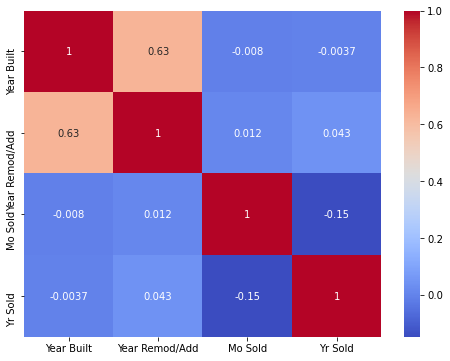

In [29]:
# quant_time = ['Year Built','Year Remod/Add', 'Yr Sold', 'Mo Sold','Yr Sold']

X = train_hold[quant_time]
y = train_hold['SalePrice']

print(f'Correlation with SalePrice:\n{X.corrwith(y).sort_values()}')

fig1 = plt.figure(figsize = (8,6))
sns.heatmap(X.corr(), annot = True, cmap='coolwarm')

Year Built
Correlation: Year Built    0.572813
dtype: float64
R2 score: 0.32811462808535596
Train set: cross_val_score: -64912.284935549695
Train set: root_mean_squared_error: 64973.71834706989


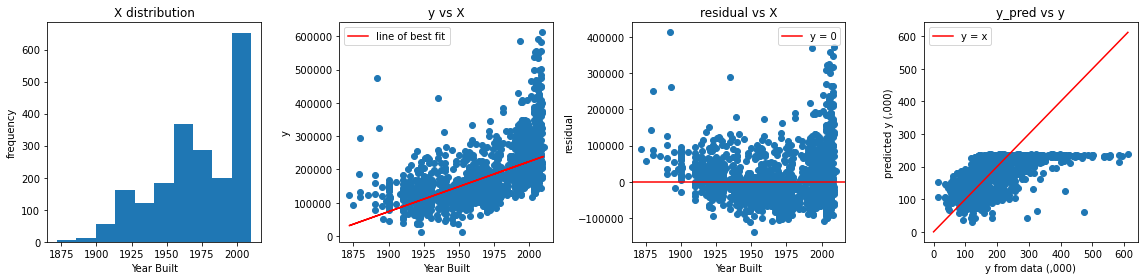

Year Remod/Add
Correlation: Year Remod/Add    0.550558
dtype: float64
R2 score: 0.3031140089824991
Train set: cross_val_score: -66101.77376875222
Train set: root_mean_squared_error: 66171.5024695236


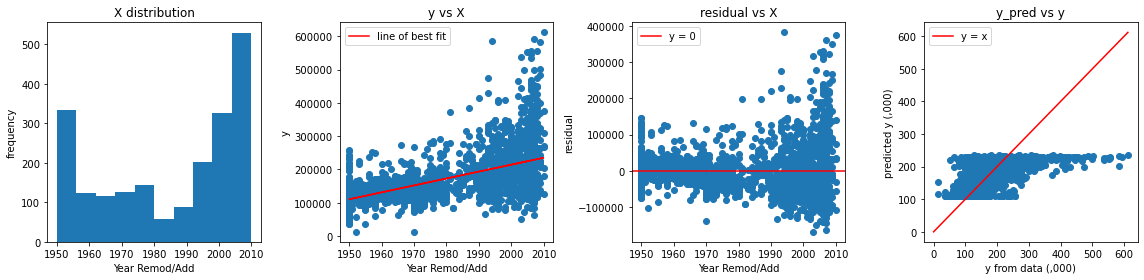

Mo Sold
Correlation: Mo Sold    0.031639
dtype: float64
R2 score: 0.001001019990401586
Train set: cross_val_score: -79233.69164842593
Train set: root_mean_squared_error: 79226.8977797813


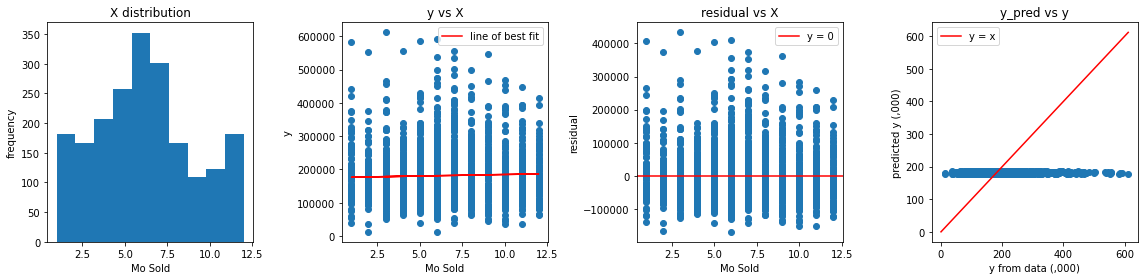

Yr Sold
Correlation: Yr Sold   -0.0153
dtype: float64
R2 score: 0.00023410288469671858
Train set: cross_val_score: -79307.87045079046
Train set: root_mean_squared_error: 79257.30261882319


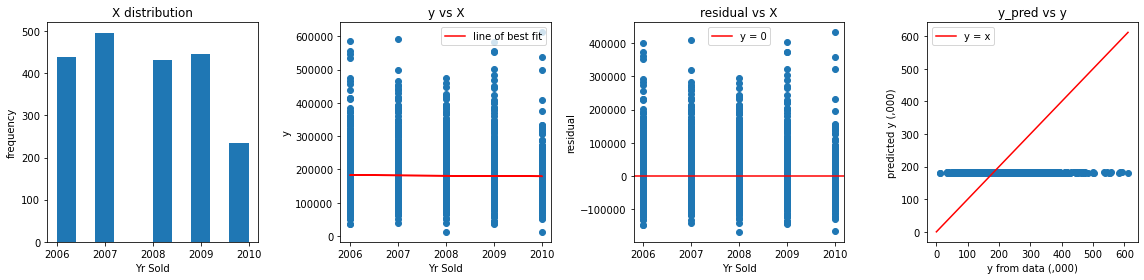

In [30]:
myeda(X,y)

'Year Bulit' and 'Year Remod/Add' have strong correlation with 'SalePrice'. However they also have strong correlation with one another. 'Mo Sold' and 'Yr Sold' do not have much correlation with 'SalePrice' 

We will choose 1 of 'Year Built' and 'Year Remod/Add'. 'Mo Sold', we will not consider. 'Yr Sold' might be incorportated into 'Year Built' or 'Year Remod/Add' by subtraction.

Correlation with SalePrice:
Kitchen AbvGr    -0.125622
Bsmt Half Bath   -0.045621
Bedroom AbvGr     0.135256
Half Bath         0.282393
Bsmt Full Bath    0.284666
Fireplaces        0.472786
TotRms AbvGrd     0.508692
Full Bath         0.537626
dtype: float64


<AxesSubplot:>

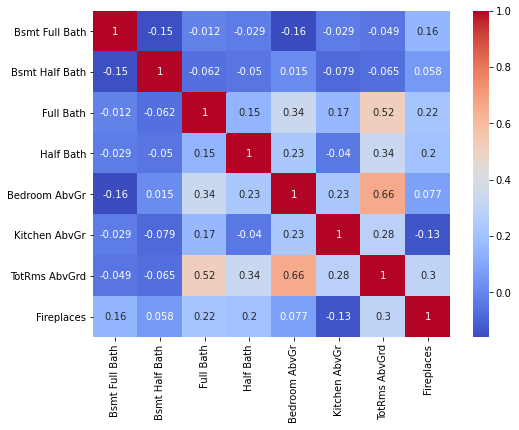

In [31]:
quant_room = ['Bsmt Full Bath','Bsmt Half Bath','Full Bath','Half Bath',
            'Bedroom AbvGr','Kitchen AbvGr','TotRms AbvGrd','Fireplaces']

X = train_hold[quant_room]
y = train_hold['SalePrice']

print(f'Correlation with SalePrice:\n{X.corrwith(y).sort_values()}')

fig1 = plt.figure(figsize = (8,6))
sns.heatmap(X.corr(), annot = True, cmap='coolwarm')

Bsmt Full Bath
Correlation: Bsmt Full Bath    0.284666
dtype: float64
R2 score: 0.08103468626800914
Train set: cross_val_score: -75964.33790479209
Train set: root_mean_squared_error: 75987.06814738308


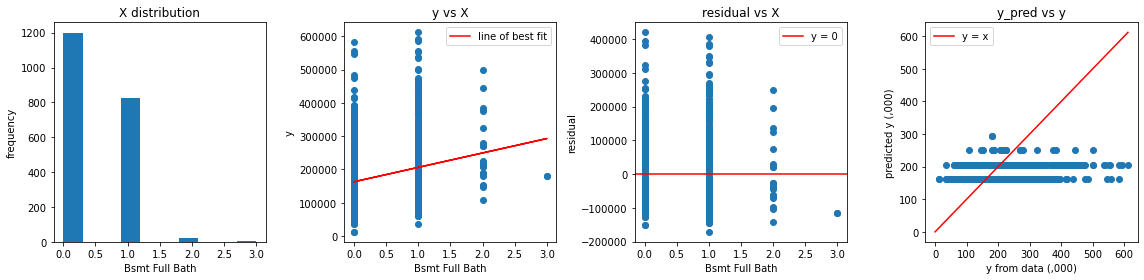

Bsmt Half Bath
Correlation: Bsmt Half Bath   -0.045621
dtype: float64
R2 score: 0.002081283429882008
Train set: cross_val_score: -79192.46137226772
Train set: root_mean_squared_error: 79184.05035334644


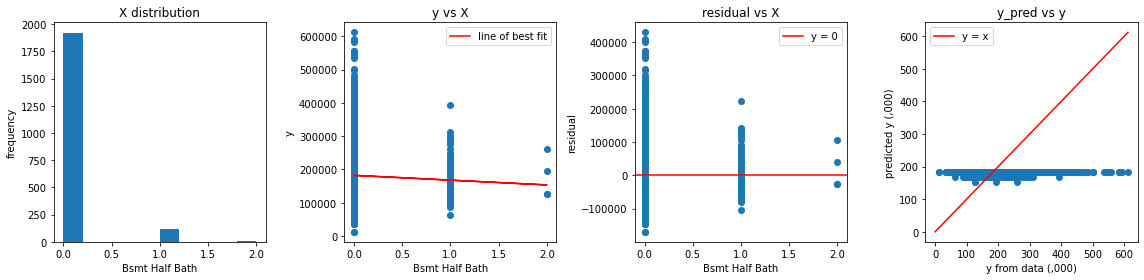

Full Bath
Correlation: Full Bath    0.537626
dtype: float64
R2 score: 0.2890421040397314
Train set: cross_val_score: -66885.57424579727
Train set: root_mean_squared_error: 66836.2491811141


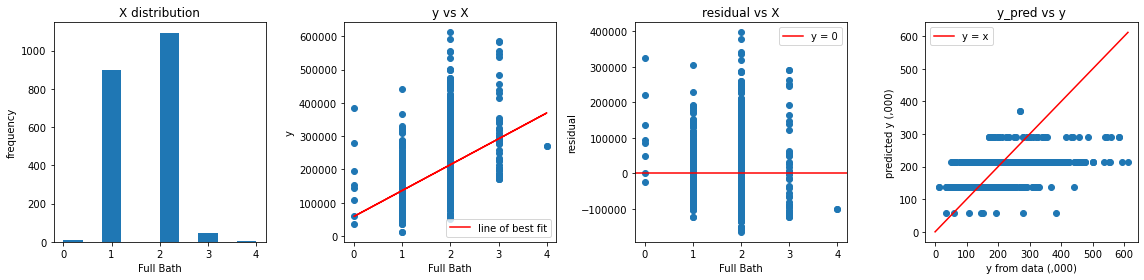

Half Bath
Correlation: Half Bath    0.282393
dtype: float64
R2 score: 0.07974600900075957
Train set: cross_val_score: -76037.82836706775
Train set: root_mean_squared_error: 76040.3283196114


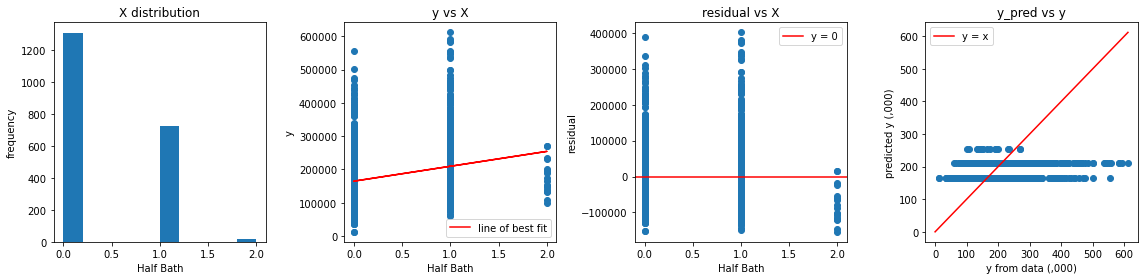

Bedroom AbvGr
Correlation: Bedroom AbvGr    0.135256
dtype: float64
R2 score: 0.018294133915046418
Train set: cross_val_score: -78630.48667509932
Train set: root_mean_squared_error: 78538.17794689792


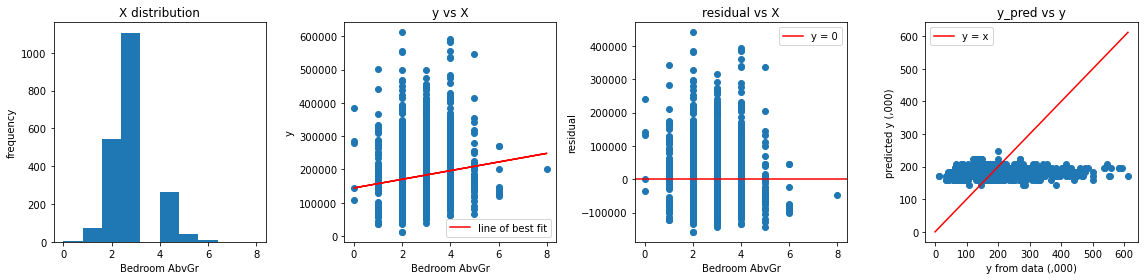

Kitchen AbvGr
Correlation: Kitchen AbvGr   -0.125622
dtype: float64
R2 score: 0.015780812313495374
Train set: cross_val_score: -78652.85792433815
Train set: root_mean_squared_error: 78638.6487340258


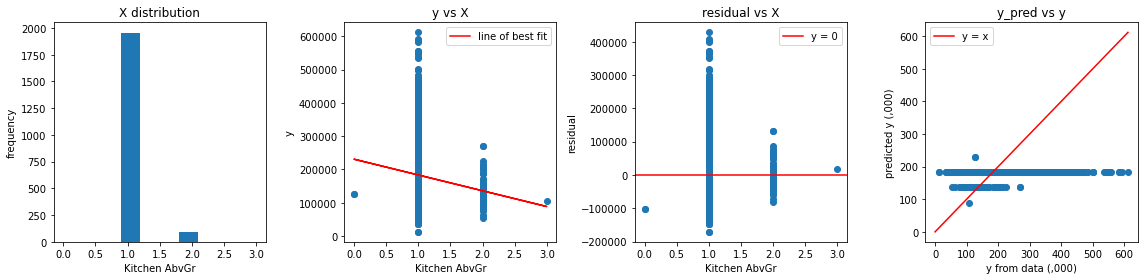

TotRms AbvGrd
Correlation: TotRms AbvGrd    0.508692
dtype: float64
R2 score: 0.25876712254390544
Train set: cross_val_score: -68329.08796167876
Train set: root_mean_squared_error: 68244.47006012211


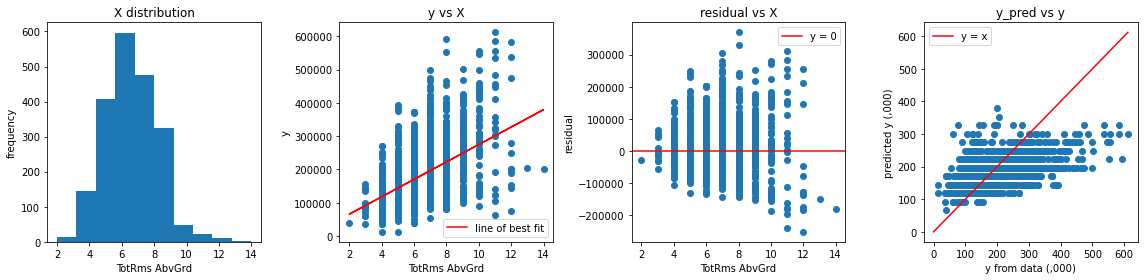

Fireplaces
Correlation: Fireplaces    0.472786
dtype: float64
R2 score: 0.2235262884185255
Train set: cross_val_score: -69849.64319431243
Train set: root_mean_squared_error: 69847.92468773272


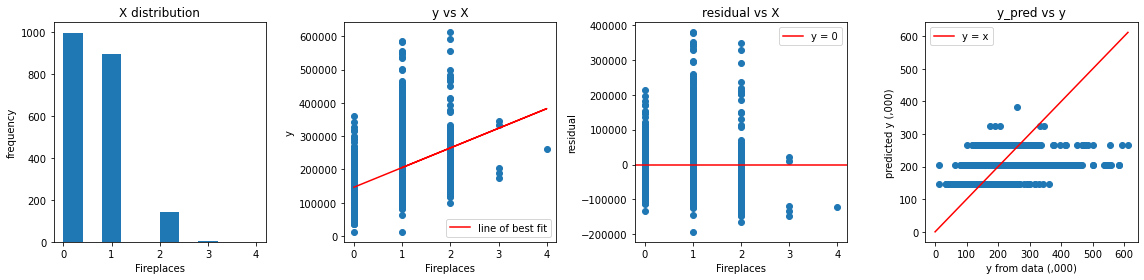

In [32]:
myeda(X,y)

'Full bath', 'TotRms AbvGrd' and 'Fireplaces' have strong correlation with 'SalePrice'. However 'Full bath' and 'Fireplaces' data distribution is quite concentrated within in few categories. We might consider putting 'Full bath' and 'Fireplaces' into qualitative data.

We will choose 'TotRms AbvGrd'.

#### ii. Continuous

Correlation with SalePrice:
BsmtFin SF 2     0.016360
Bsmt Unf SF      0.191111
BsmtFin SF 1     0.446761
Total Bsmt SF    0.667636
dtype: float64


<AxesSubplot:>

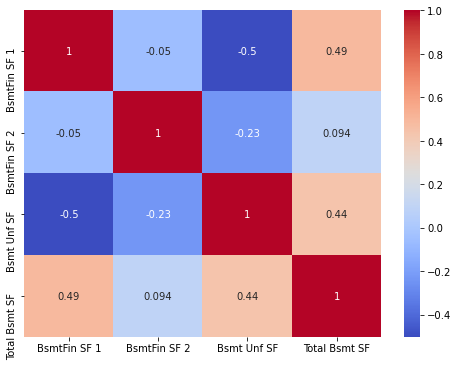

In [33]:
# quant_bsmt = ['BsmtFin SF 1','BsmtFin SF 2','Bsmt Unf SF','Total Bsmt SF']

X = train_hold[quant_bsmt]
y = train_hold['SalePrice']

print(f'Correlation with SalePrice:\n{X.corrwith(y).sort_values()}')

fig1 = plt.figure(figsize = (8,6))
sns.heatmap(X.corr(), annot = True, cmap='coolwarm')

BsmtFin SF 1
Correlation: BsmtFin SF 1    0.446761
dtype: float64
R2 score: 0.19959533725892364
Train set: cross_val_score: -70872.12803173924
Train set: root_mean_squared_error: 70916.11466015445


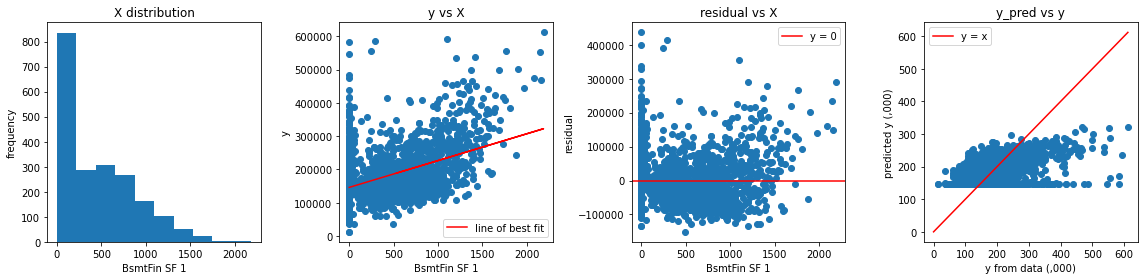

BsmtFin SF 2
Correlation: BsmtFin SF 2    0.01636
dtype: float64
R2 score: 0.0002676518012896256
Train set: cross_val_score: -79256.64407283903
Train set: root_mean_squared_error: 79255.97279803723


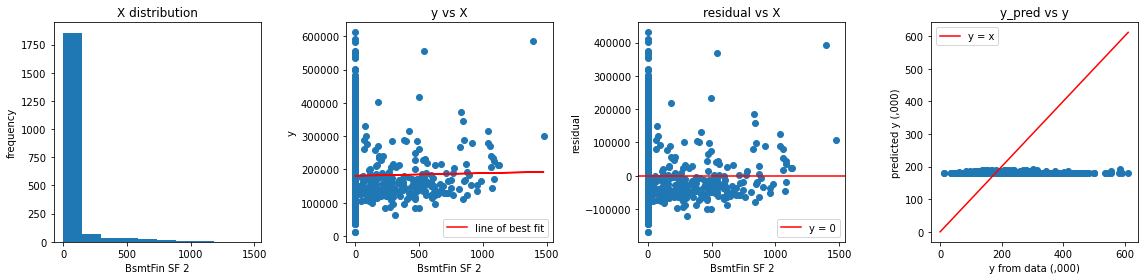

Bsmt Unf SF
Correlation: Bsmt Unf SF    0.191111
dtype: float64
R2 score: 0.0365235551162173
Train set: cross_val_score: -77898.06641721472
Train set: root_mean_squared_error: 77805.56831770008


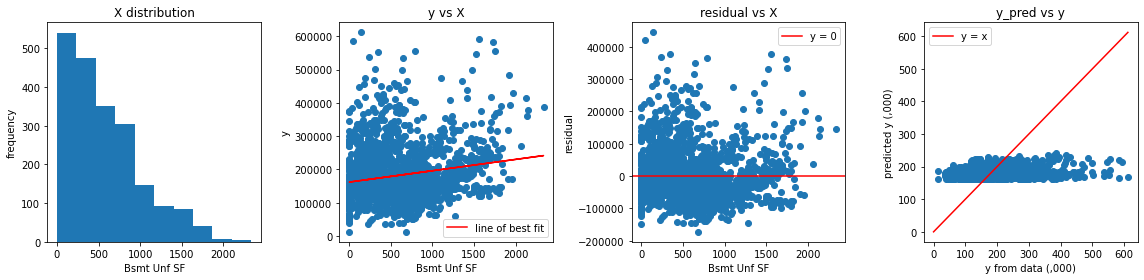

Total Bsmt SF
Correlation: Total Bsmt SF    0.667636
dtype: float64
R2 score: 0.4457377358532193
Train set: cross_val_score: -59002.98566951752
Train set: root_mean_squared_error: 59013.0123936958


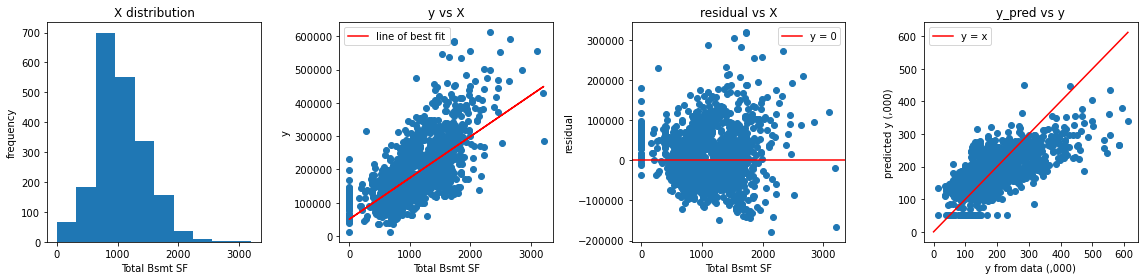

In [34]:
myeda(X,y)

'Total Bsmt SF' have strong correlation with 'SalePrice' and 'BsmtFin SF1' have moderate correlation. However both have moderate correlation with one another so we might only choose 1 of these 2. Other features have low correlation.

We will choose 'Total Bsmt SF' at this moment. We might consider doing some Polynominal or Log transformation on it as its y vs X graph display some heteroskedasticity.

Correlation with SalePrice:
2nd Flr SF     0.249466
1st Flr SF     0.651810
Gr Liv Area    0.720781
dtype: float64


<AxesSubplot:>

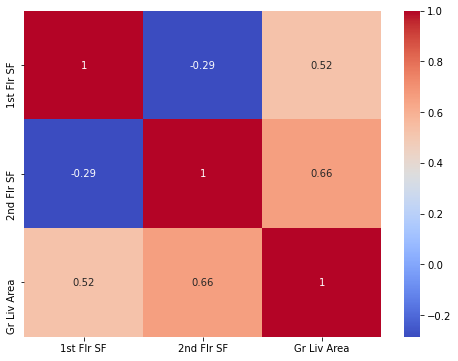

In [35]:
# quant_flr = ['1st Flr SF','2nd Flr SF','Gr Liv Area']

X = train_hold[quant_flr]
y = train_hold['SalePrice']

print(f'Correlation with SalePrice:\n{X.corrwith(y).sort_values()}')

fig1 = plt.figure(figsize = (8,6))
sns.heatmap(X.corr(), annot = True, cmap='coolwarm')

1st Flr SF
Correlation: 1st Flr SF    0.65181
dtype: float64
R2 score: 0.42485604415800904
Train set: cross_val_score: -60125.20361342574
Train set: root_mean_squared_error: 60114.385031146456


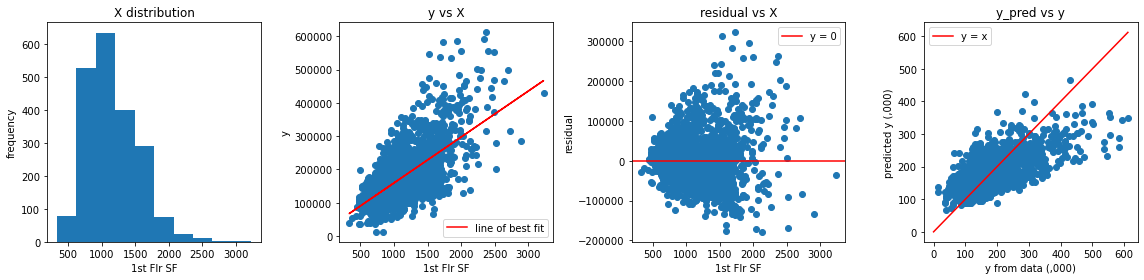

2nd Flr SF
Correlation: 2nd Flr SF    0.249466
dtype: float64
R2 score: 0.062233486828233264
Train set: cross_val_score: -76842.32783779022
Train set: root_mean_squared_error: 76760.44587844054


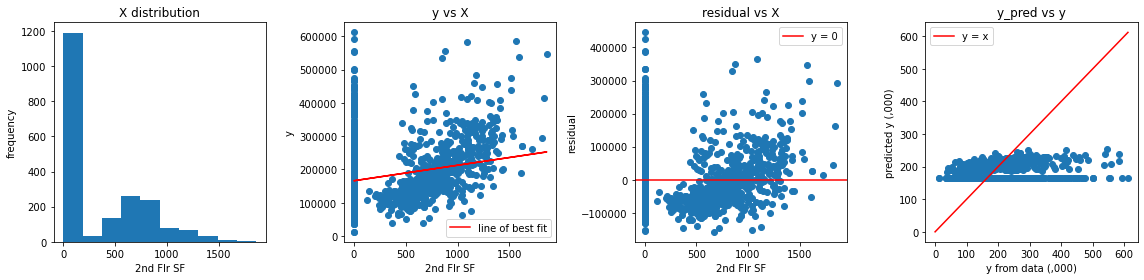

Gr Liv Area
Correlation: Gr Liv Area    0.720781
dtype: float64
R2 score: 0.5195258218779544
Train set: cross_val_score: -54960.763981131735
Train set: root_mean_squared_error: 54944.617559981576


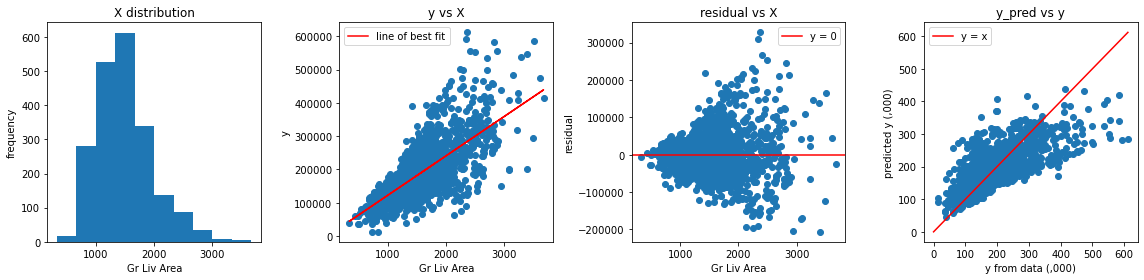

In [36]:
myeda(X,y)

'Gr Liv Area' and '1st Flr SF' have strong correlation with 'SalePrice' and 'BsmtFin SF1' have moderate correlation. However both have moderate correlation with one another so we might only choose 1 of these 2. Other features have low correlation.

We are undecided between both at this moment and will try combinations of them. We might consider doing some Polynominal or Log transformation on it as its y vs X graph display some heteroskedasticity.

Correlation with SalePrice:
Enclosed Porch   -0.135573
3Ssn Porch        0.048744
Screen Porch      0.134626
Open Porch SF     0.337205
dtype: float64


<AxesSubplot:>

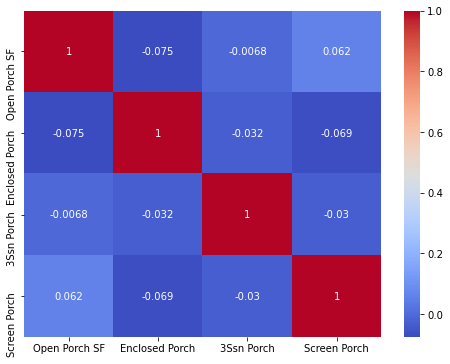

In [37]:
# quant_porch = ['Open Porch SF','Enclosed Porch','3Ssn Porch','Screen Porch']

X = train_hold[quant_porch]
y = train_hold['SalePrice']

print(f'Correlation with SalePrice:\n{X.corrwith(y).sort_values()}')

fig1 = plt.figure(figsize = (8,6))
sns.heatmap(X.corr(), annot = True, cmap='coolwarm')

Open Porch SF
Correlation: Open Porch SF    0.337205
dtype: float64
R2 score: 0.11370705738531062
Train set: cross_val_score: -74603.70835419027
Train set: root_mean_squared_error: 74624.04290655327


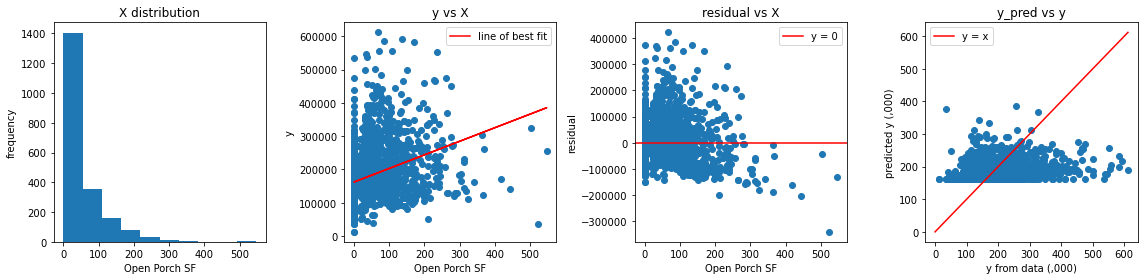

Enclosed Porch
Correlation: Enclosed Porch   -0.135573
dtype: float64
R2 score: 0.018379912264343767
Train set: cross_val_score: -78533.14081771304
Train set: root_mean_squared_error: 78534.74666332206


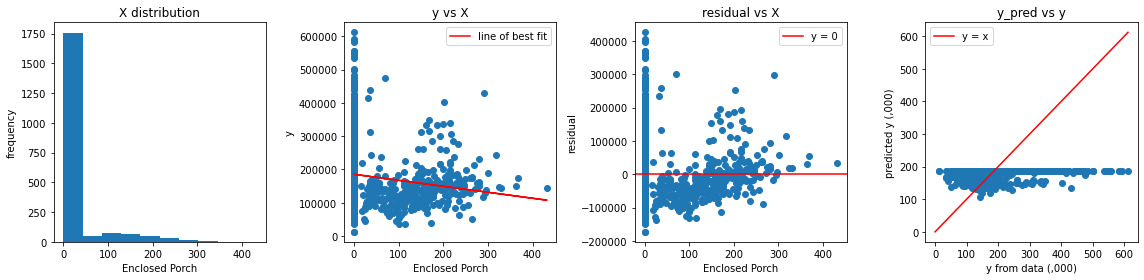

3Ssn Porch
Correlation: 3Ssn Porch    0.048744
dtype: float64
R2 score: 0.0023759981883895165
Train set: cross_val_score: -79341.62684067401
Train set: root_mean_squared_error: 79172.3567999795


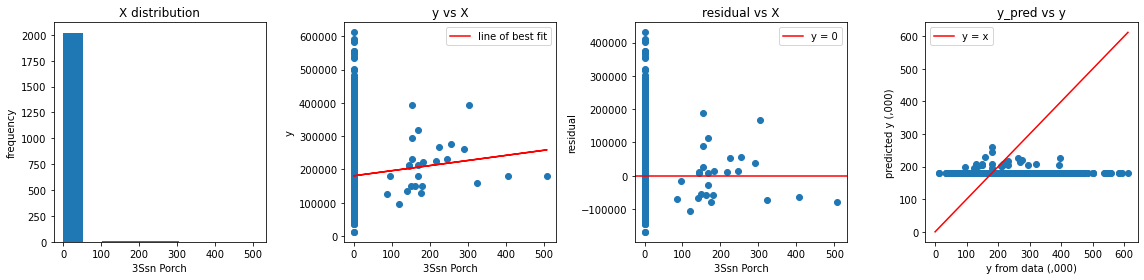

Screen Porch
Correlation: Screen Porch    0.134626
dtype: float64
R2 score: 0.018124194899733603
Train set: cross_val_score: -78598.29747854065
Train set: root_mean_squared_error: 78544.97536124465


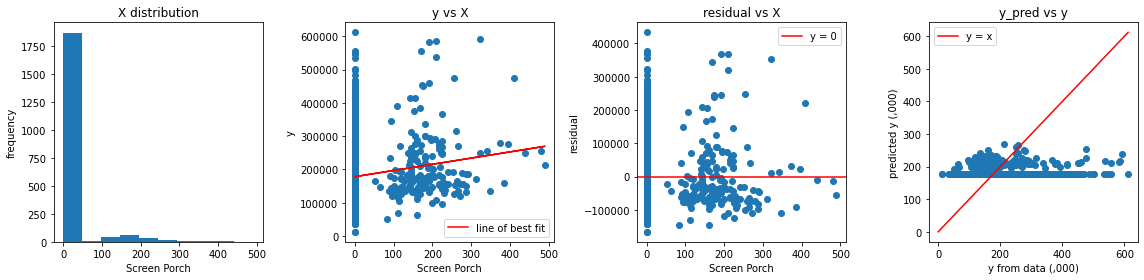

In [38]:
myeda(X,y)

None of these features show much correlationship with 'SalePrice' and their distribution are too narrow to be considered as good features.

Correlation with SalePrice:
Low Qual Fin SF   -0.041664
Misc Val          -0.010350
Lot Frontage       0.185248
Lot Area           0.302379
dtype: float64


<AxesSubplot:>

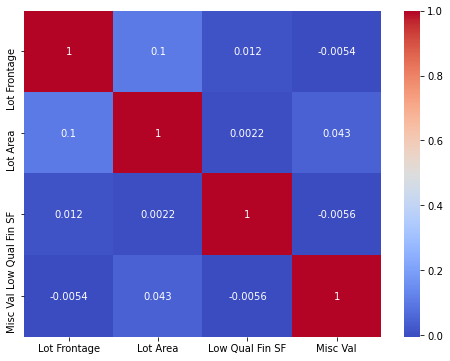

In [39]:
# quant_overall = ['Lot Frontage','Lot Area','Low Qual Fin SF','Misc Val']

X = train_hold[quant_overall]
y = train_hold['SalePrice']

print(f'Correlation with SalePrice:\n{X.corrwith(y).sort_values()}')

fig1 = plt.figure(figsize = (8,6))
sns.heatmap(X.corr(), annot = True, cmap='coolwarm')

Lot Frontage
Correlation: Lot Frontage    0.185248
dtype: float64
R2 score: 0.03431680505460233
Train set: cross_val_score: -77943.26879046271
Train set: root_mean_squared_error: 77894.62043822792


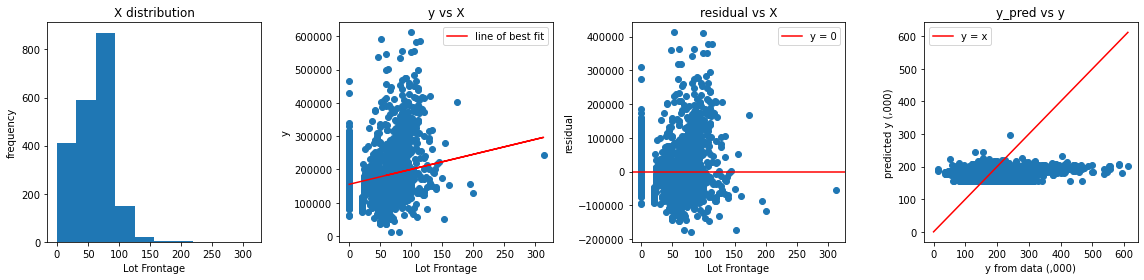

Lot Area
Correlation: Lot Area    0.302379
dtype: float64
R2 score: 0.09143315465777391
Train set: cross_val_score: -77236.6495561458
Train set: root_mean_squared_error: 75555.93268133634


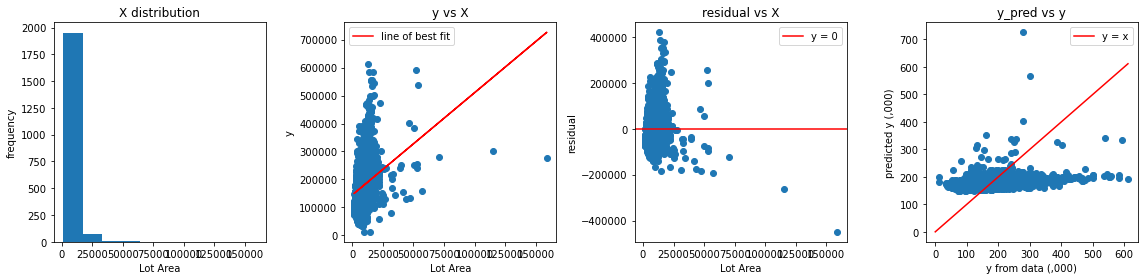

Low Qual Fin SF
Correlation: Low Qual Fin SF   -0.041664
dtype: float64
R2 score: 0.0017358859650458136
Train set: cross_val_score: -79282.26157021176
Train set: root_mean_squared_error: 79197.75267379837


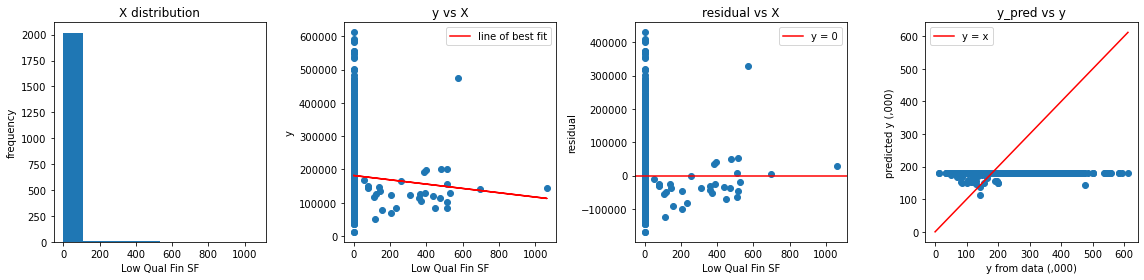

Misc Val
Correlation: Misc Val   -0.01035
dtype: float64
R2 score: 0.00010712386257327733
Train set: cross_val_score: -79245.35495410363
Train set: root_mean_squared_error: 79262.3356446933


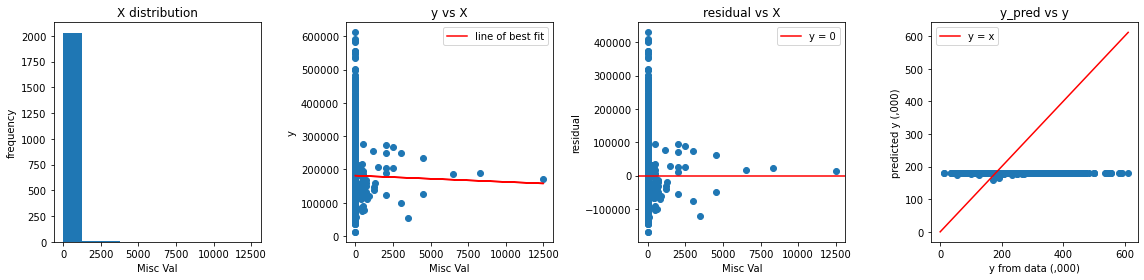

In [40]:
myeda(X,y)

None of these features show much correlationship with 'SalePrice'. At most only 'Lot Area' is worth considering as it have the highest correlation in this group but even then it is only 0.3.

Correlation with SalePrice:
Pool Area       0.025817
Wood Deck SF    0.328149
Mas Vnr Area    0.511729
Garage Cars     0.648549
Garage Area     0.655214
dtype: float64


<AxesSubplot:>

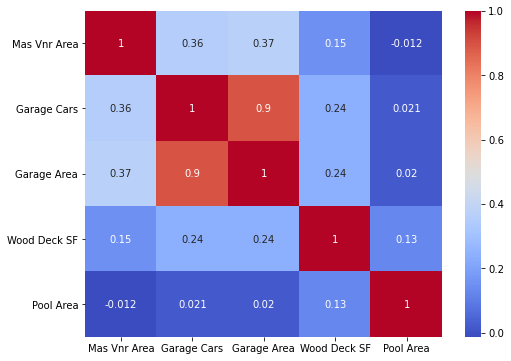

In [41]:
# quant_rest = ['Mas Vnr Area', 'Garage Cars', 'Garage Area', 'Wood Deck SF', 'Pool Area']

X = train_hold[quant_rest]
y = train_hold['SalePrice']

print(f'Correlation with SalePrice:\n{X.corrwith(y).sort_values()}')

fig1 = plt.figure(figsize = (8,6))
sns.heatmap(X.corr(), annot = True, cmap='coolwarm')

Mas Vnr Area
Correlation: Mas Vnr Area    0.511729
dtype: float64
R2 score: 0.26186628536468526
Train set: cross_val_score: -68386.46683318506
Train set: root_mean_squared_error: 68101.65241795557


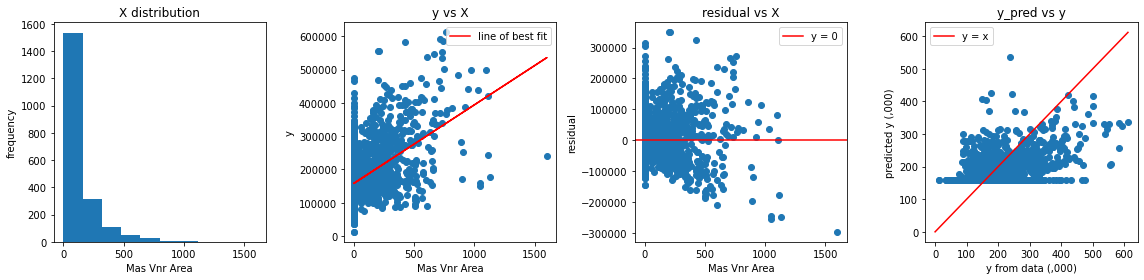

Garage Cars
Correlation: Garage Cars    0.648549
dtype: float64
R2 score: 0.42061623968221196
Train set: cross_val_score: -60358.576100111684
Train set: root_mean_squared_error: 60335.55161516907


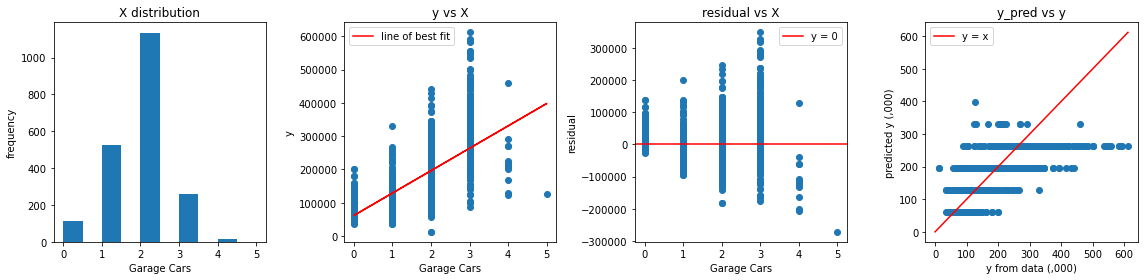

Garage Area
Correlation: Garage Area    0.655214
dtype: float64
R2 score: 0.42930586575247587
Train set: cross_val_score: -59932.59886193854
Train set: root_mean_squared_error: 59881.38449454578


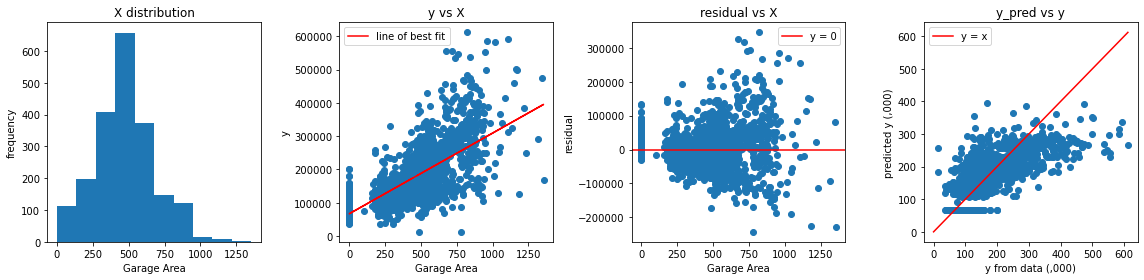

Wood Deck SF
Correlation: Wood Deck SF    0.328149
dtype: float64
R2 score: 0.10768154819462883
Train set: cross_val_score: -74897.59779696797
Train set: root_mean_squared_error: 74877.28096307897


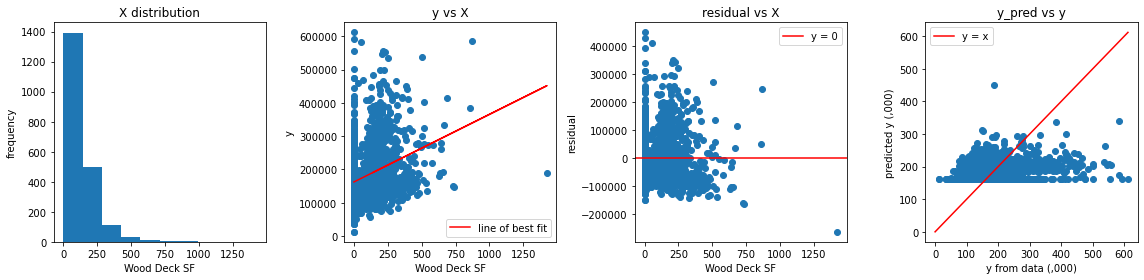

Pool Area
Correlation: Pool Area    0.025817
dtype: float64
R2 score: 0.0006664986683899699
Train set: cross_val_score: -79229.20540185021
Train set: root_mean_squared_error: 79240.1614911579


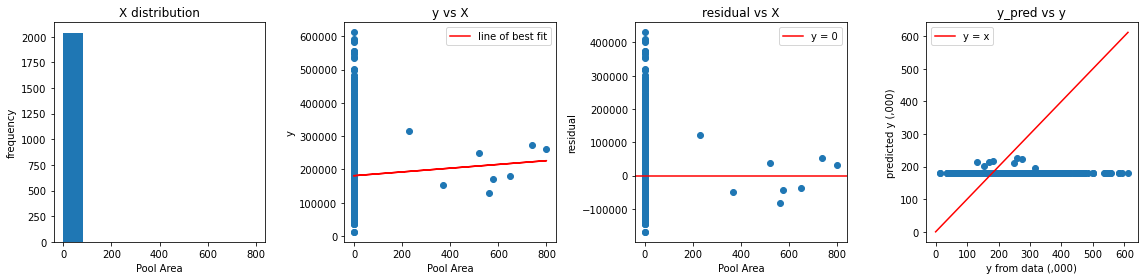

In [42]:
myeda(X,y)

'Garage Area', 'Garage Cars' and 'Mas Vnr Area' have strong correlation with 'SalePrice'. 

However 'Garage Area' and 'Garage Car' are strongly correlated at 0.9. We will only choose 'Garage Area' as its distribution is continuous compared to Garage Cars. We will also choose 'Mas Vnr Area' Other features have low correlation. We might consider doing some Polynominal or Log transformation on it as its y vs X graph display some heteroskedasticity.

### b. Qualitative

#### i. Ordinal

In [43]:
# managing the features that can be ranked / binary

def ordinaltransform(df, col, inplace = False):
    
    '''
    DocString
    ----------
    To rank the features in the database starting with 0 being the poorest/none

       
    Parameters:
    ----------
    df:              Pandas DataFrame which contains the data
    col:             Columns whose data are ordinal to be ranked
    inplace:         True / False. To change the dataframe in place
    
    '''
    
    dict =  {
            'Street': {x: idx for idx, x in enumerate(['Grvl', 'Pave'])},
            'Alley' : {x: idx for idx, x in enumerate(['None','Grvl', 'Pave'])},
            'Lot Shape' : {x: idx for idx, x in enumerate(['Reg', 'IR1', 'IR2', 'IR3'][::-1])},
            'Utilities' : {x: idx for idx, x in enumerate(['AllPub', 'NoSewr','NoSeWa', 'ELO'][::-1])},
            'Land Slope' : {x: idx for idx, x in enumerate(['Gtl','Mod', 'Sev'][::-1])},
            'Exter Qual' : {x: idx for idx, x in enumerate(['Ex','Gd','TA','Fa','Po'][::-1])},
            'Exter Cond' : {x: idx for idx, x in enumerate(['Ex','Gd','TA','Fa','Po'][::-1])},
            'Bsmt Qual' : {x: idx for idx, x in enumerate(['Ex','Gd','TA','Fa','Po','None'][::-1])},
            'Bsmt Cond' : {x: idx for idx, x in enumerate(['Ex','Gd','TA','Fa','Po','None'][::-1])},
            'Bsmt Exposure' : {x: idx for idx, x in enumerate(['Gd', 'Av', 'Mn', 'No', 'None'][::-1])},
            'BsmtFin Type 1' : {x: idx for idx, x in enumerate(['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ' ,'Unf', 'None'][::-1])},
            'BsmtFin Type 2' : {x: idx for idx, x in enumerate(['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ' ,'Unf', 'None'][::-1])},
            'Heating QC' : {x: idx for idx, x in enumerate(['Ex','Gd','TA','Fa','Po'][::-1])},
            'Central Air' : {x: idx for idx, x in enumerate(['N', 'Y'])},
            'Electrical' : {x: idx for idx, x in enumerate(['SBrkr','FuseA', 'FuseF', 'FuseP', 'Mix'][::-1])},
            'Kitchen Qual' : {x: idx for idx, x in enumerate(['Ex','Gd','TA','Fa','Po'][::-1])},
            'Functional' : {x: idx for idx, x in enumerate(['Typ', 'Min1', 'Min2','Mod', 'Maj1', 'Maj2', 'Sev', 'Sal'][::-1])},
            'Fireplace Qu' : {x: idx for idx, x in enumerate(['Ex','Gd','TA','Fa','Po','None'][::-1])},
            'Garage Finish' : {x: idx for idx, x in enumerate(['Fin', 'RFn', 'Unf', 'None'][::-1])},
            'Garage Qual' : {x: idx for idx, x in enumerate(['Ex','Gd','TA','Fa','Po','None'][::-1])},
            'Garage Cond' : {x: idx for idx, x in enumerate(['Ex','Gd','TA','Fa','Po','None'][::-1])},
            'Paved Drive' : {x: idx for idx, x in enumerate(['Y','P','N'][::-1])},
            'Pool QC' : {x: idx for idx, x in enumerate(['Ex','Gd','TA','Fa','None'][::-1])},
            'Fence'  : {x: idx for idx, x in enumerate(['GdPrv', 'MnPrv','GdWo', 'MnWw', 'None'][::-1])},
            'Overall Qual' : {},
            'Overall Cond': {}
            }
    if inplace:
        for column in col:
            df[column].replace(dict[column], inplace = inplace)
    
    else:
        temp = df.copy(deep=True)
        for column in col:
            temp[column].replace(dict[column], inplace = True)
        return temp

In [44]:
def qualitative_boxplots(df,target, corr=False):
    
    '''
    DocString
    ----------
    To do Exploratory Data Analysis on individual features (qualitative data)
    Display boxplot of features against target.
       
    Parameters:
    ----------
    X:               Pandas DataFrame with data of the features to be explored
    y:               Array/Series of the target which the features are to be compared against
    corr:            To display correlation (after X is ranked)
    
    Return:          No return
    
    '''
    
    nrows = int(np.ceil(len(df.columns)/2))

    fig, ax = plt.subplots(nrows=nrows, ncols=2,figsize=(16,6*nrows))
    ax = ax.ravel()
    
    if len(df.columns) % 2 != 0:
        plt.delaxes(ax=ax[len(df.columns)])
        
    columns = list(df.columns)
    temp = df.copy(deep = True)
    temp['SalePrice'] = target
    
    for i, column in enumerate(columns):
        ax[i].set_title(column)
        ax[i].set_ylabel('SalePrice')
        sns.boxplot(x=column, y='SalePrice', data = temp, ax=ax[i])
        if df[column].nunique() > 10:
            ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation = 'vertical')
        if corr:
            ax[i].text(x = 0, y= 500000, s = f'Corr: {temp[[column]].corrwith(target)[0]:.3f}')

    fig.tight_layout()
    plt.show()

In [45]:
# create a dataframe for ordinal features after ranking them
train_ordinal = ordinaltransform(train_hold, col = ordinal, inplace = False)

In [46]:
train_ordinal['Street'].nunique()

2

In [47]:
X = train_ordinal[ordinal]
y = train_hold['SalePrice']

print(f'Correlation with SalePrice:\n{X.corrwith(y).sort_values()}')

Correlation with SalePrice:
Lot Shape        -0.297059
Fence            -0.157650
Alley            -0.097585
Overall Cond     -0.097191
Land Slope       -0.057979
BsmtFin Type 2    0.014013
Utilities         0.026436
Pool QC           0.035555
Exter Cond        0.036383
Street            0.069921
Functional        0.125869
Bsmt Cond         0.228278
Electrical        0.246888
Garage Cond       0.265562
Central Air       0.277728
Garage Qual       0.285906
Paved Drive       0.290855
BsmtFin Type 1    0.351686
Bsmt Exposure     0.426909
Heating QC        0.459609
Fireplace Qu      0.538812
Garage Finish     0.559367
Bsmt Qual         0.618485
Kitchen Qual      0.694157
Exter Qual        0.715785
Overall Qual      0.804236
dtype: float64


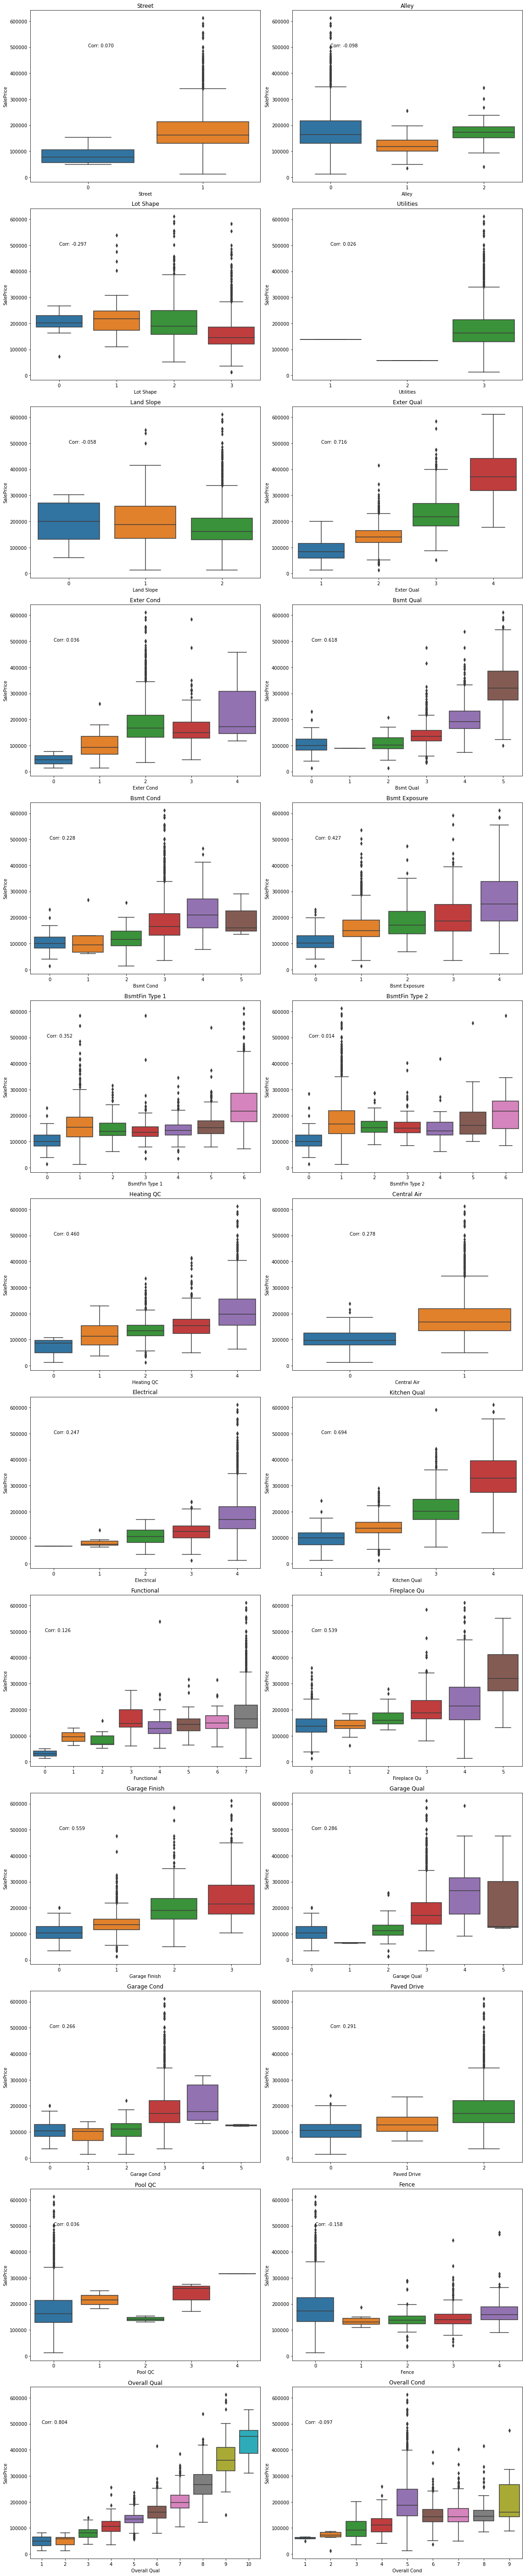

In [48]:
qualitative_boxplots(X,y,corr=True)

*'Exter Qual', 'Bsmt Qual', 'Bsmt Exposure', 'Heating QC', 'Kitchen Qual', 'Fireplace Qu', 'Garage Finish', 'Overall Qual'* have correlation higher than 0.4. *'Exter Qual', Bsmt Qual', 'Kitchen Qual,'Overall Qual'* have least overlap between their ranks and span the range of SalePrice much more than the other features in this group

<AxesSubplot:>

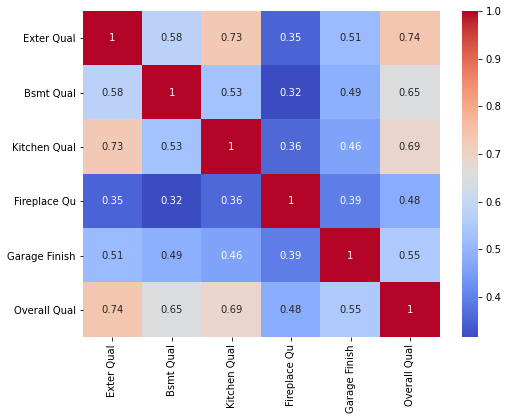

In [49]:
X = train_ordinal[[x for x in X.columns if abs(X.corrwith(y)[x]) > 0.5]]
y = train_hold['SalePrice']

fig1 = plt.figure(figsize = (8,6))
sns.heatmap(X.corr(), annot = True, cmap='coolwarm')

*'Overall Qual'* is highly correlated will all the others. Either we put in *'Overall Qual'* or we put in the other features

Exter Qual
Correlation: Exter Qual    0.715785
dtype: float64
R2 score: 0.512348167266507
Train set: cross_val_score: -55297.854488399564
Train set: root_mean_squared_error: 55353.49648556055


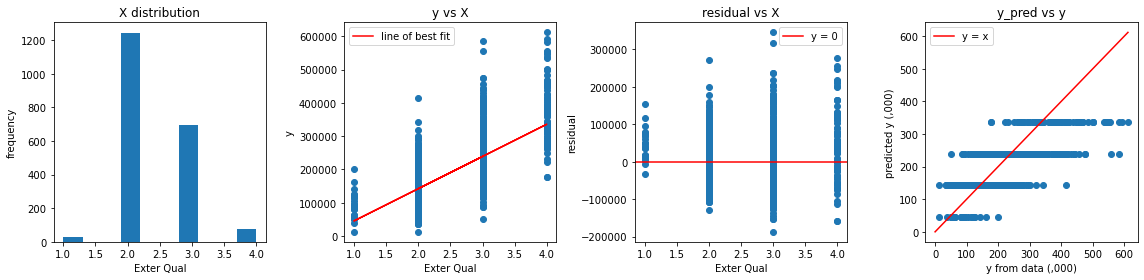

Bsmt Qual
Correlation: Bsmt Qual    0.618485
dtype: float64
R2 score: 0.38252430668150905
Train set: cross_val_score: -62265.9192511186
Train set: root_mean_squared_error: 62287.37975466092


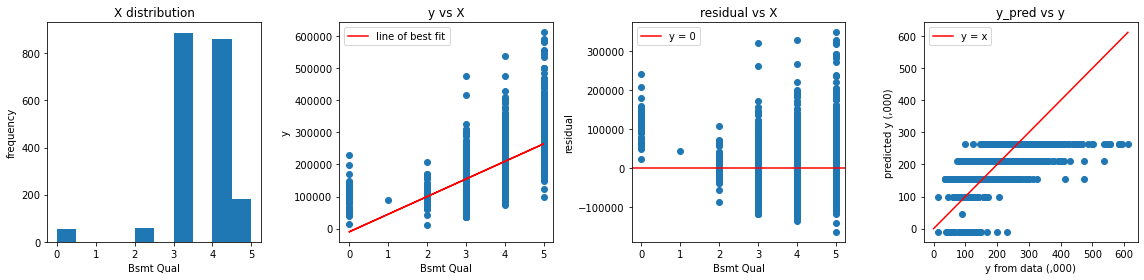

Kitchen Qual
Correlation: Kitchen Qual    0.694157
dtype: float64
R2 score: 0.48185349917246567
Train set: cross_val_score: -57069.491547098514
Train set: root_mean_squared_error: 57057.982747426155


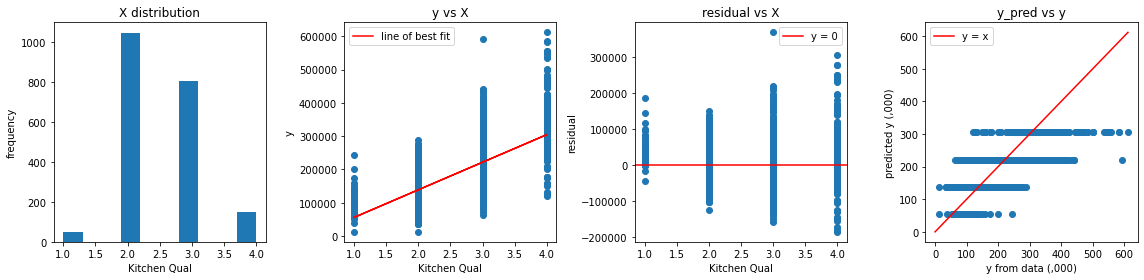

Fireplace Qu
Correlation: Fireplace Qu    0.538812
dtype: float64
R2 score: 0.29031819512637813
Train set: cross_val_score: -66756.89744681344
Train set: root_mean_squared_error: 66776.24039025066


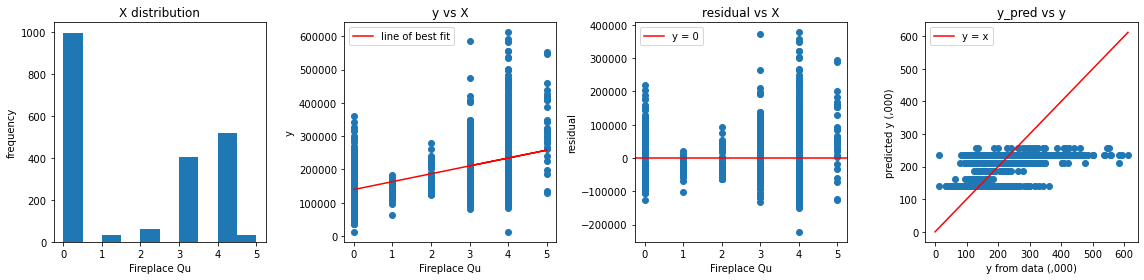

Garage Finish
Correlation: Garage Finish    0.559367
dtype: float64
R2 score: 0.3128919068127878
Train set: cross_val_score: -65663.29673216147
Train set: root_mean_squared_error: 65705.64161544605


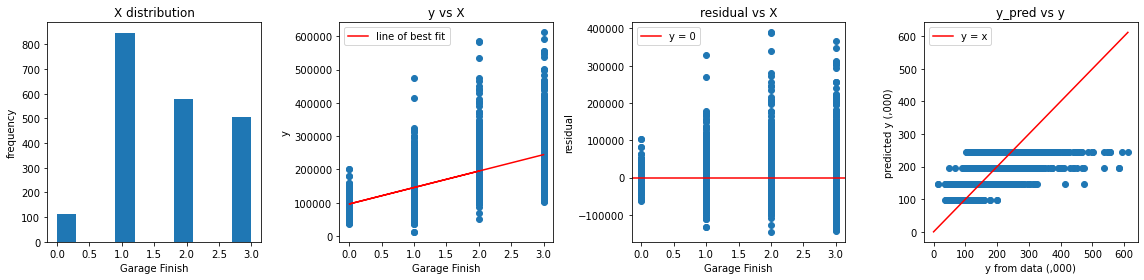

Overall Qual
Correlation: Overall Qual    0.804236
dtype: float64
R2 score: 0.6467958432088192
Train set: cross_val_score: -47122.047134856824
Train set: root_mean_squared_error: 47108.90738417122


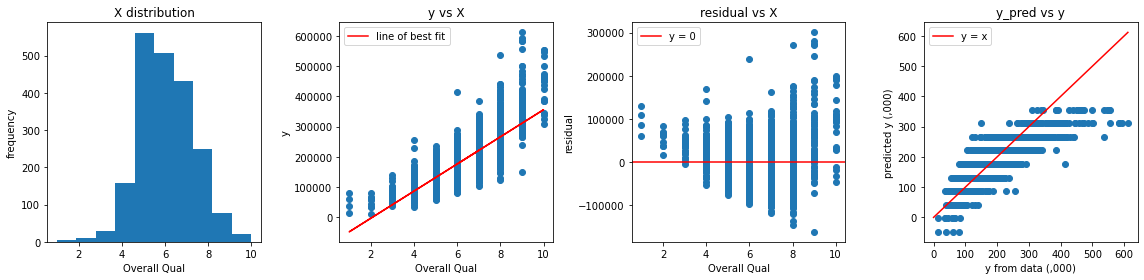

In [50]:
myeda(X,y)

Looking at the residual vs X graphs, 'Overall Qual' have the best distribution and correlation but have heteroskedasticity. Also it is the only feature that have a category of smaller variance that cover the range where y is > 500,000.

#### ii. Nominal

In [51]:
X = train_hold[nominal]
y = train_hold['SalePrice']

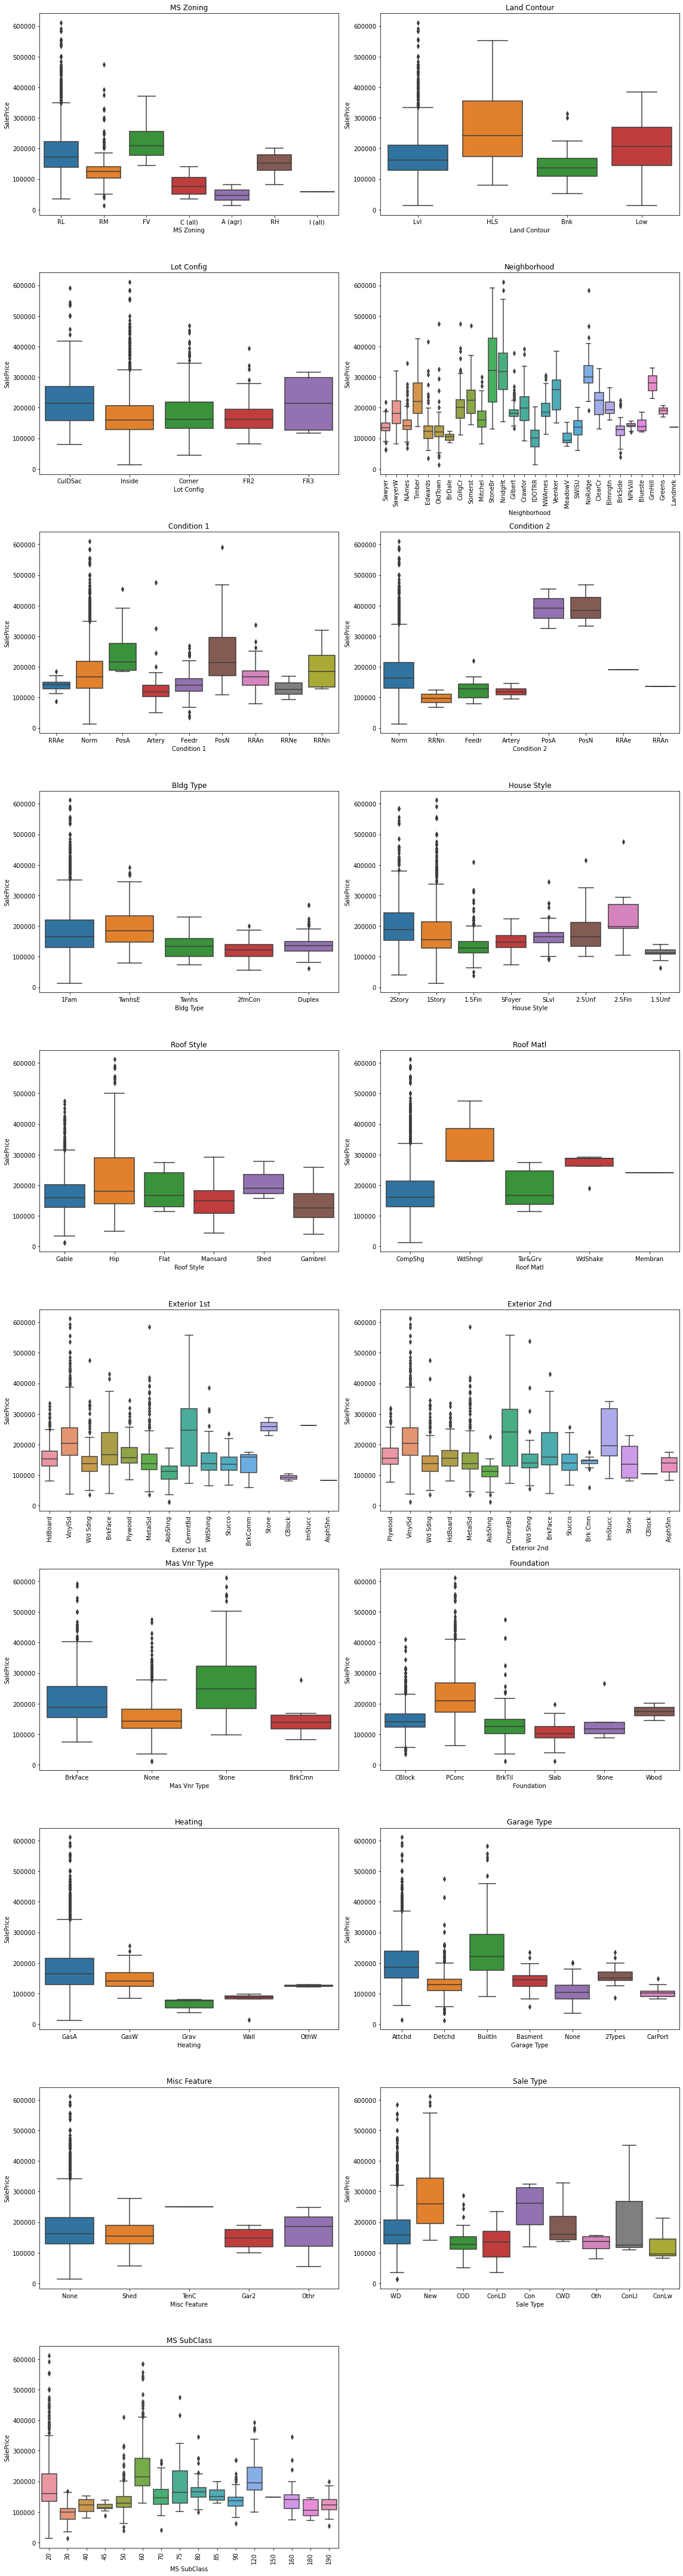

In [52]:
qualitative_boxplots(X,y)

Most of the boxplots here do not clearly distinct between different range of SalePrice. Only *'MS Zoning', 'Condition 1', 'Roof Matl', 'Heating', 'Garage Type', 'Sale Type' and 'MS SubClass'* have boxplots with the least overlaps so they can distinct different range of SalePrice better. We will include them in the model. *'Neighborhood','Exterior 1st' and 'Exterior 2nd'* have many categories> This might be a challenge when we do OneHotEncoding. *'Land Contour','Mas Vnr Type','Foundation'* have more overlaps than the aboves features but less than the rest. We can consider them but they are not our first choice features.

### c. Features Selection Summary

We have selected 13 features as our 1st choice features. They are as followed:  
'Year Built', 'TotRms AbvGrd', 'Total Bsmt SF', 'Gr Liv Area', 'Garage Area', 'Misc Val'  
'Overall Qual'  
'MS Zoning', 'Condition 1', 'Roof Matl', 'Heating', 'Garage Type', 'Sale Type' and 'MS SubClass'

At the same time, we selected another 11 features as our 2nd choice features. They can be used to replace or supplement the features in the above group if they help to improve the final model. They are as followed:  
'Year Remod/Add', '1st Flr SF', 'Lot Area'  
'Exter Qual', 'Bsmt Qual', 'Kitchen Qual', 'Fireplace Qu', 'Garage Finish'  
'Neighborhood', 'Exterior 1st', 'Exterior 2nd'

These features are selected based on their correlation with SalePrice and that they are less independent of each other. Also they are selected based that they span across more of the range of SalePrice and their categories help to separate different range of SalePrice.